In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:

dataTraining = pd.read_csv('https://github.com/camilobarajas1990/Otros/raw/master/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/camilobarajas1990/Otros/raw/master/dataTesting.zip', encoding='UTF-8', index_col=0)


Iniciamos creando una copia de las bases de datos originales

In [3]:
train = dataTraining
test = dataTesting

## 1.1 Exploración variable respuesta

Realizamos una exploración inicial de a base de datos para descubrir la cantidad inicial de géneros a los cuales podría pertenecer cada película. Adicionalmente queremos saber a cuántos géneros pertenece aproximadamente cada película. 

In [4]:
# 1.1 Exploración variable respuesta
# Crear DF de variable respuesta
train['genres'] = train['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = pd.DataFrame(le.fit_transform(train['genres']), columns=(list(le.classes_)))
y_genres.shape # Son 24 tipos de género


(7895, 24)

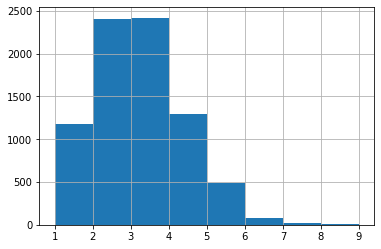

In [5]:
y_genres['num_gen'] = y_genres.sum(axis=1)
y_genres['num_gen'].hist(bins=8)
y_genres["num_gen"].value_counts()
# Hay 2 películas que se clasifican en 9 géneros y 8 que se clasifican en 7 géneros

y_genres = y_genres.drop(columns='num_gen')

Para la futura creación de variables consideramos importante saber el año de lanzamiento de las películas, con el fin se sabes si hay algún tipo de relación entre este y su género. Con esto descubrimos que las películas son recientes en su mayoría 

2013    288
2012    277
2009    268
2008    268
2011    266
2007    263
2006    259
2014    242
2010    234
2005    223
2004    202
1997    184
2001    179
2002    176
2000    169
1999    168
1998    168
1995    167
2003    161
1996    158
1994    137
1988    136
1993    135
1992    124
1990    124
1991    123
1989    117
1987    116
1985     91
1986     90
       ... 
1935     28
1960     28
1937     26
1961     26
1932     23
1933     23
1938     19
1931     17
1934     16
1928     15
1921      9
1925      8
1922      8
1930      8
1929      7
1923      7
1927      7
1924      6
1926      6
1920      5
1916      5
1915      5
1917      3
1919      3
1894      2
1918      2
1910      1
1914      1
1903      1
1896      1
Name: year, Length: 106, dtype: int64

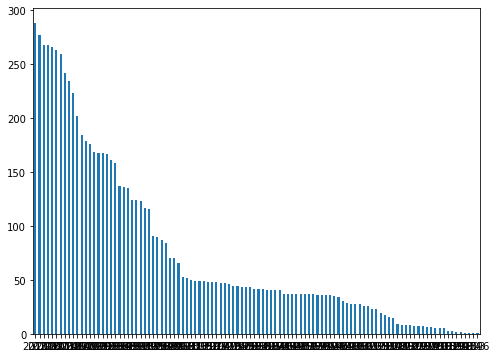

In [6]:
# Año de lanzamiento de la película
pd.Series(train['year']).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0)
train["year"].value_counts()

## 1.2 Creación de Variables

Para hacer que el año de estreno de la película provea mayor información al modelo, remplazamos la variable año por el número de años que han pasado desde que se estrenó la película. 

6      288
7      277
11     268
10     268
8      266
12     263
13     259
5      242
9      234
14     223
15     202
22     184
18     179
17     176
19     169
21     168
20     168
24     167
16     161
23     158
25     137
31     136
26     135
27     124
29     124
28     123
30     117
32     116
34      91
33      90
      ... 
83      28
59      28
82      26
58      26
87      23
86      23
81      19
88      17
85      16
91      15
98       9
89       8
97       8
94       8
96       7
90       7
92       7
93       6
95       6
104      5
99       5
103      5
102      3
100      3
101      2
125      2
123      1
116      1
109      1
105      1
Name: time, Length: 106, dtype: int64

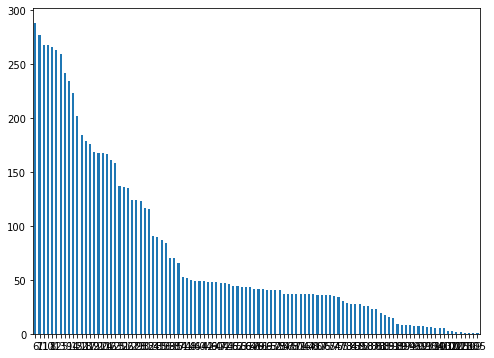

In [7]:
train['time'] = 2019-train['year']
pd.Series(train['time']).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0)
train["time"].value_counts()

Además de la variable anterior, contamos el número de palabras en la descripción y el título de cada película, para dar la mayor cantidad de información al modelo

In [8]:
train['totalwords'] = train['plot'].str.split().str.len()
train["totalwords"].value_counts()
train.loc[train['totalwords']<=10,['plot','genres']]

,plot,genres
2145,"three workers , zeke (","[Crime, Drama]"
214,a look at the life of filmmaker john milius .,"[Documentary, Biography, Drama]"
3546,several voice actors discuss their art and the...,[Documentary]
6782,a series of comedic short films guaranteed to ...,[Comedy]
7444,how,[Documentary]
3352,"iconic writer , director , actor , comedian...","[Documentary, Biography]"
4832,an authorized documentary on the late musician,"[Documentary, Animation, Biography, Music]"
4110,the feature film directing debut of,"[Crime, Mystery, Romance]"
2485,the third installment of the faces of death se...,"[Documentary, Horror]"
9425,a retelling of sir,"[Documentary, History]"


## 2. Limpieza de los textos

Haciendo uso de la librería NLTK renovemos las “Stop Words” y los signos de puntuación. Este proceso de hace tanto para el título de la película como para la descripción 

In [9]:
train['Puntuacion']= train['plot'].str.count('!')+train['plot'].str.count(',')+train['plot'].str.count('\.')+train['plot'].str.count('\?')

In [10]:
train['words_punt'] = train['totalwords']/train['Puntuacion']
train['words_punt']= train['words_punt'].replace(np.Inf,0)

In [11]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [12]:
train['plot'] = train['plot'].apply(remove_punctuation)

In [13]:
train['title'] = train['title'].apply(remove_punctuation)

In [14]:
import nltk
nltk.download('stopwords')
# nltk library
sw = stopwords.words('english')  
np.array(sw)
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### se crea una funcion para remover Stop Words

In [15]:
def stopwords(text):
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [16]:
train['plot'] = train['plot'].apply(stopwords)

In [17]:
train['title'] = train['title'].apply(stopwords)

### 2.2.1 Revisión de top words antes de hacer stemming

In [18]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(train['plot'])
dictionary = count_vectorizer.vocabulary_.items() 

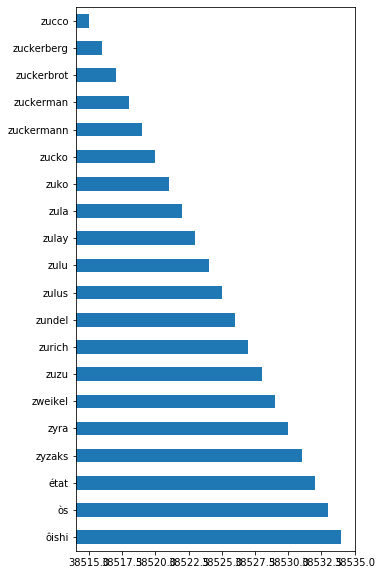

In [19]:
# Store the vocab and counts in a pandas dataframe
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in pandas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

#Bar plot of top words before stemming
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (38514, 38535))

## 2.3 Stemming

In [20]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [21]:
train['plot'] = train['plot'].apply(stemming)

In [22]:
train['title'] = train['title'].apply(stemming)


### 2.3.1 Revisión de top words después de hacer stemming

In [23]:
tfid_vectorizer = TfidfVectorizer("english")
tfid_vectorizer.fit(train['plot'])
dictionary = tfid_vectorizer.vocabulary_.items()  

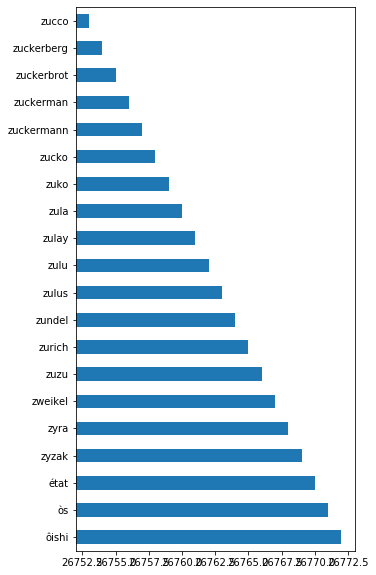

In [24]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (26752, 26773))

# 3. creación del modelo a implementar

In [25]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [26]:
#Create count vectorizer
vect = TfidfVectorizer(max_features=16000, ngram_range=(1,2),tokenizer=tokenize,min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,smooth_idf=1, sublinear_tf=1 )
vect0 = TfidfVectorizer(max_features=1400, ngram_range=(1,2),tokenizer=tokenize,min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,smooth_idf=1, sublinear_tf=1 )


El modelo de elección fue un random forest classifier, el cual tuvo el mejor rendimiento entre los modelos ensayados. Entro los otros modelos se encuentran el XGboostig y el perceptrón multicapa

In [27]:
X_dtm = pd.DataFrame(vect.fit_transform(train['plot']).toarray(), index=train.index,columns=vect.get_feature_names())
X_dtm0 =pd.DataFrame(vect0.fit_transform(train['title']).toarray(), index=train.index,columns=vect0.get_feature_names())

Time = pd.DataFrame(train.time, columns=['time'],index=X_dtm.index)
time2 = Time^2

Pun =train[['Puntuacion']]

w = pd.DataFrame(normalize(train[['totalwords']],norm='max',axis=0), columns=['Words'],index=X_dtm.index)

#wpun = train[['words_punt']]

Frames = [X_dtm,X_dtm0,Time,time2,w, Pun]#wpun]

X_tot = pd.concat(Frames, axis=1)


In [28]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_tot, y_genres, test_size=0.40, random_state=5)

In [29]:
clf = RandomForestClassifier(n_estimators=700, max_depth=15, random_state=2,n_jobs=-1, max_features = 'sqrt')
clf1 = RandomForestClassifier(n_estimators=700, max_depth=15, random_state=845,n_jobs=-1,max_features = 'sqrt')
clf2 = RandomForestClassifier(n_estimators=700, max_depth=15, random_state=54,n_jobs=-1,max_features = 'sqrt')


In [30]:
eclf = OneVsRestClassifier(VotingClassifier(estimators=[('rf', clf), ('rf1', clf1),('rf2',clf2)],voting='soft', weights=[1,1,1],flatten_transform=False))


Como método de cross validation, se usó un K-folds con 5 divisiones en la base de datos, con la intención de recorrer toda la base de datos

In [31]:

from sklearn.model_selection import KFold

In [32]:
cv = KFold(n_splits=5, random_state=78, shuffle=False)
resultcv =[]


In [33]:
for trainf, testf in cv.split(X_tot):
    Xtrain = X_tot.iloc[trainf]
    Ytrain = y_genres.iloc[trainf]
    Xtest  = X_tot.iloc[testf]
    Ytest  = y_genres.iloc[testf]
    eclf.fit(Xtrain,Ytrain)
    y_pred_genres = pd.DataFrame(eclf.predict_proba(Xtest),columns=(list(le.classes_)))
    try:
        resultcv.append(roc_auc_score(Ytest, y_pred_genres, average='macro'))
    except ValueError:
        pass

In [34]:
resultcv

[0.8738697611288547, 0.8766959287479281, 0.8734373952569907]

Los resultados arriba son el porcentage de predicciones correctas fcomo resultdos de cada uno de los Folds de la validación cruzada efectuada.

In [35]:
y_pred_genres = pd.DataFrame(eclf.predict_proba(X_test), index=X_test.index,columns=(list(le.classes_)))

In [36]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.9736373889582932

con la unión de los modelos realizados arriba, se tiene una predicción correcta de 97% sobre la base se datos de train

# 4. Aplicar el mismo tratamiento a la base de test

In [37]:
test['time'] = 2019-test['year']
test['totalwords'] = test['plot'].str.split().str.len()
test['Puntuacion']= test['plot'].str.count('!')+test['plot'].str.count(',')+test['plot'].str.count('\.')

p=test[['Puntuacion']]

w3=pd.DataFrame(normalize(test[['totalwords']],norm='max',axis=0), columns=['Words'],index=test.index)

test['plot'] = test['plot'].apply(remove_punctuation)
test['title'] = test['title'].apply(remove_punctuation)

test['plot'] = test['plot'].apply(stopwords)
test['title'] = test['title'].apply(stopwords)

test['plot'] = test['plot'].apply(stemming)
test['title'] = test['title'].apply(stemming)


Time_test = pd.DataFrame(test.time, columns=['time'],index=test.index)
Time_test2 = Time_test^2

vect_test = pd.DataFrame(vect.transform(test['plot']).toarray(), index=test.index,columns=vect.get_feature_names())
vect_test0 = pd.DataFrame(vect0.transform(test['title']).toarray(), index=test.index,columns=vect0.get_feature_names())

Frames_Test = [vect_test, vect_test0 ,Time_test,Time_test2,w3,p]

X_tot_test = pd.concat(Frames_Test, axis=1)

#X_Def_Tot = X_tot_test.groupby(level=0, axis=1).max()

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

ypred = pd.DataFrame(eclf.predict_proba(X_tot_test),index=test.index,columns=cols)

In [38]:
ypred.to_csv('df.csv',index_label='ID')

In [39]:
ypred

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.133784,0.114958,0.023931,0.034109,0.389965,0.134017,0.031340,0.525158,0.068285,0.082450,...,0.029508,0.076826,0.000065,0.282096,0.068765,0.032724,0.022965,0.218561,0.025419,0.017202
4,0.158265,0.097251,0.026721,0.101183,0.358524,0.199156,0.040574,0.554242,0.076626,0.071834,...,0.030007,0.070083,0.011157,0.178113,0.065025,0.006146,0.023214,0.233305,0.048585,0.020991
5,0.140635,0.103739,0.022463,0.039739,0.302214,0.352267,0.032212,0.608315,0.067860,0.077250,...,0.026493,0.164086,0.000480,0.248674,0.072107,0.006142,0.022515,0.386515,0.028888,0.017233
6,0.135017,0.108316,0.021988,0.037366,0.314191,0.141308,0.028486,0.556220,0.068794,0.073751,...,0.033670,0.092988,0.001011,0.258851,0.102427,0.005608,0.020904,0.284344,0.049771,0.026301
7,0.136168,0.138152,0.065026,0.032999,0.320724,0.177996,0.029385,0.411348,0.094101,0.114787,...,0.047201,0.103542,0.000036,0.195955,0.226995,0.007345,0.021585,0.228906,0.033103,0.028160
9,0.124872,0.097775,0.023061,0.056028,0.361073,0.153613,0.043802,0.505107,0.069797,0.080469,...,0.035441,0.073115,0.001623,0.193133,0.067058,0.009788,0.037205,0.217640,0.038990,0.027846
11,0.215017,0.155156,0.023462,0.047788,0.377301,0.176100,0.357382,0.475710,0.079761,0.098933,...,0.037246,0.069064,0.002892,0.243417,0.078722,0.006397,0.031939,0.215344,0.026797,0.019101
13,0.203474,0.117593,0.023125,0.033229,0.486025,0.246814,0.028583,0.498386,0.069683,0.073631,...,0.031394,0.075731,0.000023,0.266960,0.067940,0.006020,0.028988,0.277379,0.024288,0.016410
16,0.125254,0.101911,0.021988,0.040133,0.413523,0.128892,0.035775,0.548379,0.068478,0.079206,...,0.023799,0.074766,0.000035,0.318599,0.071057,0.005625,0.022496,0.208004,0.031017,0.017743
21,0.120079,0.116407,0.024334,0.034137,0.465511,0.167130,0.038906,0.530955,0.074713,0.072844,...,0.025444,0.069419,0.000127,0.243152,0.074163,0.005591,0.020751,0.194443,0.038327,0.015805


Generar una Funcion para la prediccion 

In [44]:
def predict_proba(Year,title,plot):
    
    
    d = {'year': [Year], 'title': [title], 'plot':[plot]}
    df2 = pd.DataFrame.from_dict(d)
    
    #-- Transformación de variablesbbdd

    df2['time'] = 2019-df2['year'] #Transformación de year
    #df2['titlewords'] = df2['title'].str.split().str.len() #Conteo palabras titulo 'titlewords'
    df2['totalwords'] = df2['plot'].str.split().str.len() #Creación variable totalwords
    df2['Puntuacion']= df2['plot'].str.count('!')+df2['plot'].str.count(',')+df2['plot'].str.count('\.')+df2['plot'].str.count('\?') #Conteo palabras plot 'Puntuacion'
    #Creación variables puntuación
    
    
    #- Remover puntuación
    df2['title'] = df2['title'].apply(remove_punctuation) #Titulo
    df2['plot'] = df2['plot'].apply(remove_punctuation) #Plot 
    
    #- Remover stopwords
    df2['title'] = df2['title'].apply(stopwords) #Titulo
    df2['plot'] = df2['plot'].apply(stopwords) #Plot
    
    #- Stemming
    df2['title'] = df2['title'].apply(stemming) #Titulo
    df2['plot'] = df2['plot'].apply(stemming) #Plot

    #Vectorizar   
    X_dtm = pd.DataFrame(vect.transform(df2['plot']).toarray(), index=df2.index,columns=vect.get_feature_names())
    X_dtm0 = pd.DataFrame(vect0.transform(df2['title']).toarray(), index=df2.index,columns=vect0.get_feature_names())

    Time = pd.DataFrame(df2.time, columns=['time'],index=X_dtm.index)
    time2 = Time^2
    Pun =df2[['Puntuacion']]
    w = pd.DataFrame(normalize(df2[['totalwords']],norm='max',axis=0), columns=['Words'],index=X_dtm.index)
    
    Frames = [X_dtm,X_dtm0,Time,time2,Pun,w]
    X_tot = pd.concat(Frames, axis=1)
    
    # Make prediction
    pred = eclf.predict_proba(X_tot)
    cols = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
        'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
        'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']
    pred = pd.DataFrame(pred, columns = cols, index = ['probabilidad'])
    pred = pred.transpose()
    
            
    return pred

In [42]:
Title = 'John Wick: Chapter 3 – Parabellum'
Year= 2019
Plot = 'Less than an hour after the conclusion of the previous film, former hitman John Wick is now a marked man and on the run in Manhattan. After the unsanctioned killing of crime lord and new member of the High Table Santino D Antonio in the New York City Continental, John is declared excommunicado by his handlers at the High Table and placed under a $14 million bounty. On the run from assassins, John reaches the New York Public Library and recovers a crucifix necklace and a marker medallion from a secret cache in a book. He fights his way through numerous assassins populating New York City until he reaches the Director, a woman from his past who operates a theater. She accepts the crucifix as a ticket for safe passage to Casablanca, Morocco and has Wick branded to signify that he has used up all his favors. Meanwhile, an Adjudicator with the High Table meets with Winston, the manager of the New York City Continental, and the Bowery King, the leader of a network of vagrant assassins. The Adjudicator admonishes both for helping John Wick kill Santino D Antonio, and both are given seven days to give up their offices or face serious consequences.'

In [45]:
predict_proba(Year,Title,Plot)

,probabilidad
Action,0.301073
Adventure,0.129999
Animation,0.022785
Biography,0.040086
Comedy,0.336740
Crime,0.258576
Documentary,0.065042
Drama,0.493111
Family,0.095290
Fantasy,0.093429


Uso de un modelo perceptron multicapa:

Se usó un perceptrón multicapa como modelo para complementar los random forests empleados como modelos de análisis, pero a pesar de usar diversos números de capas, neuronas, y métodos de aprendizaje, sus resultaos eran peores que con el modelo originalmente planteado. 

# Clasificación de género de películas - AWS

### URL: http://52.14.252.74:8888/

![](https://raw.githubusercontent.com/ccorrea842/Proyecto-2-Kaggle/master/API.PNG)

![](https://raw.githubusercontent.com/ccorrea842/Proyecto-2-Kaggle/master/Resultado.PNG)